# Meta-Heuristic and Surrogate Methods for Optimization
Multimodal problems (with multiple local minima) cannot be solved by "exact" optimization techniques like Linear Programming (LP) or Non-Linear Programming (NLP). The aim of this repository is to introduce "global optimization" algorithms to find the global minima.

### Global Optimization Problem
Find $x^*\in \mathcal{D}\subseteq \mathbb{R}^d$ such that $f(x^*) = inf_{x\in\mathcal{D}}f(x)$
 * $\mathcal{D}$ is a compact subset of $\mathbb{R}^d$
 * $f:\mathcal{D}\rightarrow\mathbb{R}$ is a deterministic continous function (possibly non convex)
 * $f$ is costly to evaluate (e.g. output of an expensive computer simulation)
 * deriviatives of $f$ are not available.
 
### Types of Optimization Problems
 * **Linear Programming**: continous decisions
   * Advantages: Very efficient for many vairables, user friendly software, don't need to understand algorithm
   * Disadvantages: REstricted to linear mathematical form with continous variables
 * **Non linear Programming**: (continuous decisions) many variaties of algorothms but they assume just one optimum point
   * Advantage: Fastest for differentiable problems with continous variables and a non-linear but convex surface (with only one minimum)
   * Disadvantage: Cannot be used for discrete varaibles or most nonconvex problems, calculation of deriviatives can be expensive and inaccurate, high expertise required (when the algo stops searching when it shouldn't), may only find local optimum
 * **(Linear) Integer and Mixed Integer Programming**: At least some of hte varaibles are restricted to being integer valued and others might be continuous.
    * Advantages: User frindly software, for problems with a modest number of integer variables and linear functions, MIP is often the most efficient
    * Disadvantages: Restricted to linear mathematical form, computational efficiency is poor for large number of integer variables, Surrogates can be better and faster on nonlinear integer problems than IP
 * **Heuristic Optimization**: continuous and integer decision variables and multiple optima. Eg. genetic algorithms, pretty simple algorithms best for inexpensive objective functions and they usually require large number of objective function evaluations to get accurate answer.
   * Advantages: Easy to learn, easy to implement, don't stop at a local optimum and might find global minimum, tend to parallelize relatively efficiently, can address most objective function and improve the solution if given enough objective function evaluations.
   * Disadvantages: For problems that satisfy assumptions of other algorhtms, the heuristic method will probably take more CPU time and give a less accurate answer. For expensive objective functions, surrogate optimization will take less total time than heuristics. Finally, no strong theoretical background for convergence results.
 * **Surrogate Optimization**: nonlinear or global optimization that builds a local or global approximation of objective. More complex algorithms that can find solutions with relatively few objective evaluations so they are useful with computationall expensive objective functions (like simulation or stochastic models)
 
## Surrogate Global Optimization
A **surrogate approximation $s(x)$** to a continous function $f(x)$ is also called a "response surface model" or a "function approximation" or "metamodel". Such an approximation can be used to reduce the number of points at which we evaluate the expensive function $f(x)$ and thereby significantly reduce the computational cost. A common technique used to construct surrogate approximations is radial basis functions (RBF).

### Steps of a general surrogate algorithm
1. Initialization: space filling method to generate first surrogate surface. To fit the initial surrogate approximation, we need to evaluate the function at several points. To select these points, we use a [Symmetric Latin Hypercube (SLHD)](https://en.wikipedia.org/wiki/Latin_hypercube_sampling).
2. Generate surrogate response surface including the most recently evaluated points $\rightarrow$ set $A$. Essentially, fit an interpolating crve through the known values of objective function. Can use RBFs, kriging, polynomials and regression surfaces.
3. Search on response surface for next evaluation point $x^E$. This requires:
  * An optimization search procedure on the surface
  * A criterion fromt he optimization search
4. Evaluate the expensive function $f(x)$ for $x=x^E$ and store it in the set of evaluated points $A$. The algorithm used for picking the new point can depend on the current surrogate approxiamtion of the funtion, and on the location of the previous evaluations or on uncertainty estimates.
5. Update surrogate response surface to include the newest evaluation
6. If number of evaluations < max. evaluations, go to step 3

## Simple Heuristic Algorithm: Local "Greedy Search"
The problem is to use local search to find $\min cost(s)$ where $s = \{s_1, \ldots, s_m\}$ where $s$ is a vector whose components can be integer, continuous or both. All heuristic algorithms have three components:
1. Initial Solution
2. Neighborhood
3. Improvement algorithm

For the local greedy search:
1. Initial solution: randomly pick a $s_{curr}$
2. Neighborhood: search the $cost(s)$ function $\forall s\in \{s_{curr}\pm d\}$ where $d$ is the range
3. Improvement algorithm: Pick the new solution in the neighbourhood that has the best objective function to be $s_{curr}$ in the next iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint
plt.style.use('ggplot')

In [2]:
def cost(s):
    ''' returns the evaluation of the cost function
    on a numpy array of imputs
    '''
    return 0.4*np.cos(s)**3-1.5*np.sin(s)**2+0.25*s

def neighbors(s, min_s, max_s, d=2):
    neigh = np.arange(max(s-d, min_s), min(s+d+1, max_s))
    return neigh[neigh != s]

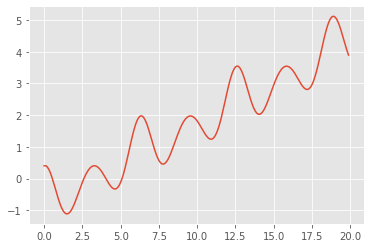

In [3]:
x = np.arange(0,20, 0.1)
y = cost(x)
plt.plot(x,y)

In [4]:
max_iter = 50
s = np.random.randint(20) # Initialization
s_hist = [s]
cost_s = cost(s)
for i in range(max_iter):
    neigh_s = neighbors(s, min_s=0, max_s=20, d=2)
    cost_neigh = cost(neigh_s)
    min_idx = np.argmin(cost_neigh)
    if cost_s >= cost_neigh[min_idx]:
        s = neigh_s[min_idx]
        cost_s = cost_neigh[min_idx]
        s_hist.append(s)
    else:
        break

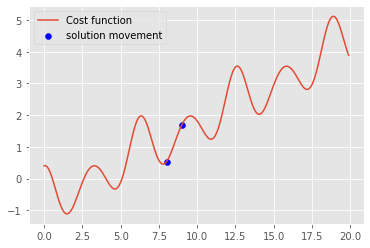

In [5]:
plt.plot(x,y)
plt.scatter(s_hist, cost(np.array(s_hist)), c='b')
plt.legend(['Cost function', 'solution movement'])

In [6]:
max_iter = 50
s = np.random.randint(20) # Initialization
s_hist = [s]
cost_s = cost(s)
for i in range(max_iter):
    neigh_s = neighbors(s, min_s=0, max_s=20, d=5)
    cost_neigh = cost(neigh_s)
    min_idx = np.argmin(cost_neigh)
    if cost_s >= cost_neigh[min_idx]:
        s = neigh_s[min_idx]
        cost_s = cost_neigh[min_idx]
        s_hist.append(s)
    else:
        break

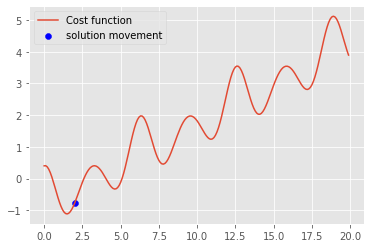

In [7]:
plt.plot(x,y)
plt.scatter(s_hist, cost(np.array(s_hist)), c='b')
plt.legend(['Cost function', 'solution movement'])

#### Selecting the neighborhood size
 * Advantage of a large neighborhood is that you are more likely to find a better next value for $s$ than with a small neighborhood and less likely to get cuaght in a local minimum.
 * Disadvantage is that you may have to evaluate *cost(s)* many times and this may be computationally demanding.
 
## Hard Problems and Heuristics
 * The evidence for the worth of different methods on different classes of large scale problems is largely empirical for NP complete problems.
 * For example, the simplex method for linear programming is NP Hard, but it has been shown empirically to be very effective at finding optimal solutions in relatively few iterations.
 * There are many problems for which heuristics perform as well as or better than existing mathematical algorithms given that we are only willing to perform a limited number of iterations.
 * In addition there are many problems for which no optimization method exists except heuristic methods.
 
## Random Walk / Random Search / Greedy Deterministic / Greedy Stochastic
Based on the observations above, 4 simple algorithms are implemented. For the purposes of using an example, the **cost function** we will optimize for is
$$Cost(s) = (400-(s-21)^2)\cdot \sin(s\pi/6)$$
The constraint on $s: s\in\mathbb{N}, 0\leq s\leq 500$.
The **neighbourhood function** that is implements below for step 2 considers $\forall s, s.t. max(s_{current}-25, 0)\leq s \leq \min(s_{current}+25, 500)$

The 4 algorithms implemented differ in their implementation of step 3, the improvement algorithm:

1. **Random Walk (RW)**: In RW, the next value of $s$ is chosen at random from the set of negihbours of $s_{current}$. The best value seen until now is saved as $s_{best}$, along with $cost(s_{best})$.
2. **Random Sampling (RS)**: In RW, the next value of $s$ is chosen at random from ALL possible values of $s (0\leq s\leq 500)$. As before, we save $s_{best}$ and $cost(s_{best})$.
3. **Greedy Deterministic (GD)**: Same as presented above, we select $s = \min_s cost(s), \forall s\in neigh(s_{current})$
4. **Greedy Stochastic (GS)**: The new value of $s$ is chosen at random from the neighbours of the current value of $s_{best}$.

In [8]:
def cost(s):
    return (400 - (s-21)**2)* np.sin(s*math.pi/6)

def random_neighbor(s, min_s = 0, max_s = 500, d = 25):
    s_new = s
    while(s_new==s):
        s_new = randint(max(s-d, min_s), min(s+d, max_s))
    return s_new

def neighbors(s, min_s = 0, max_s = 500, d = 25):
    neigh = np.arange(max(s-d, min_s), min(s+d+1, max_s))
    return neigh[neigh != s]

### Random Walk
def RW(sInitial, maxIter):
    sCurrent, sBest =  sInitial, sInitial
    costCurrent = cost(sInitial)
    costBest = costCurrent
    matrix = np.empty((maxIter, 5))
    matrix[0,:] = [0, sCurrent, sBest, costCurrent, costBest]
    for i in range(1, maxIter):
        sCurrent = random_neighbor(sCurrent) #perturb
        costCurrent = cost(sCurrent)
        if costCurrent < costBest:
            costBest = costCurrent
            sBest = sCurrent
        matrix[i,:] = [i, sCurrent, sBest, costCurrent, costBest]
    return matrix

### Random Search
def RS(sInitial, maxIter):
    sCurrent, sBest =  sInitial, sInitial
    costCurrent = cost(sCurrent)
    costBest = costCurrent
    matrix = np.empty((maxIter, 5))
    matrix[0,:] = [0, sCurrent, sBest, costCurrent, costBest]
    for i in range(1, maxIter):
        sCurrent = randint(0,500) #perturb
        costCurrent = cost(sCurrent)
        if costCurrent < costBest:
            costBest = costCurrent
            sBest = sCurrent
        matrix[i,:] = [i, sCurrent, sBest, costCurrent, costBest]
    return matrix

### Greedy Deterministic
def GD(sInitial, maxIter):
    sCurrent, costCurrent = sInitial, cost(sInitial)
    matrix = np.empty((maxIter, 5))
    matrix[0,:] = [0, sCurrent, sCurrent, costCurrent, costCurrent]
    for i in range(1, maxIter):
        neigh_s = neighbors(sCurrent, d=10)
        cost_neigh = cost(neigh_s)
        min_idx = np.argmin(cost_neigh)
        if costCurrent >= cost_neigh[min_idx]:
            sCurrent = neigh_s[min_idx]
            costCurrent = cost_neigh[min_idx]
        matrix[i,:] = [i, sCurrent, sCurrent, costCurrent, costCurrent]
    return matrix

### Greedy Stochastic  
def GS(sInitial, maxIter):
    sCurrent, costCurrent = sInitial, cost(sInitial)
    sBest, costBest = sCurrent, costCurrent
    matrix = np.empty((maxIter, 5))
    matrix[0,:] = [0, sCurrent, sBest, costCurrent, costBest]
    for i in range(1, maxIter):
        sCurrent = random_neighbor(sBest)
        costCurrent = cost(sCurrent)
        if(costCurrent < costBest):
            sBest = sCurrent
            costBest = costCurrent
        matrix[i,:] = [i, sCurrent, sBest, costCurrent, costBest]
    return matrix

In [9]:
def pretty_plot(xlim=None, ylim=None, xlabel=None, ylabel=None, title=None):
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()
    return

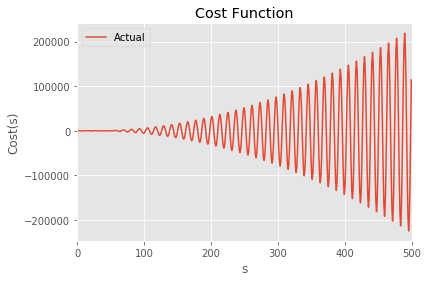

In [10]:
s = np.arange(0,500)
cost_s = np.vectorize(cost)
plt.plot(s, cost_s(s), label="Actual")
pretty_plot(xlim=(0,500), xlabel='s', ylabel='Cost(s)', title='Cost Function')

In [11]:
times = 30
maxIter = 200
result = {'RW':np.empty((times, maxIter, 5)) , 'RS':np.empty((times, maxIter, 5)), 'GD':np.empty((times, maxIter, 5)), 'GS':np.empty((times, maxIter, 5))}
for i in range(times):
    result['RW'][i] = RW(randint(0,500), maxIter)
    result['RS'][i] = RS(randint(0,500), maxIter)
    result['GD'][i] = GD(randint(0,500), maxIter)
    result['GS'][i] = GS(randint(0,500), maxIter)

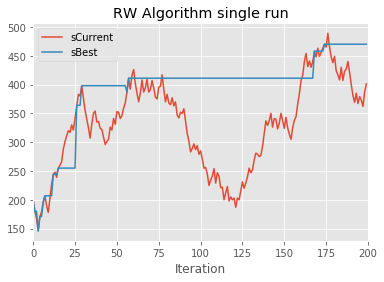

In [12]:
plt.plot(result['RS'][0,:,0], result['RW'][0,:,1], label='sCurrent')
plt.plot(result['RS'][0,:,0], result['RW'][0,:,2], label='sBest')
pretty_plot(xlim=(0,200), xlabel='Iteration', title='RW Algorithm single run')

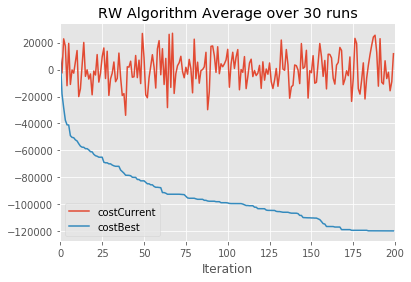

In [13]:
plt.plot(result['RW'][0,:,0], np.average(result['RW'][:,:,3], axis=0), label='costCurrent')
plt.plot(result['RW'][0,:,0], np.average(result['RW'][:,:,4], axis=0), label='costBest')
pretty_plot(xlim=(0,200), xlabel='Iteration', title='RW Algorithm Average over 30 runs')

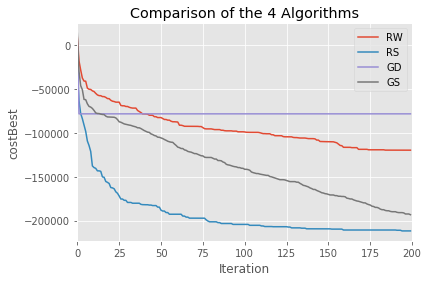

In [14]:
plt.plot(result['RW'][0,:,0], np.average(result['RW'][:,:,4], axis=0), label='RW')
plt.plot(result['RS'][0,:,0], np.average(result['RS'][:,:,4], axis=0), label='RS')
plt.plot(result['GD'][0,:,0], np.average(result['GD'][:,:,4], axis=0), label='GD')
plt.plot(result['GS'][0,:,0], np.average(result['GS'][:,:,4], axis=0), label='GS')
pretty_plot(xlim=(0,200), xlabel='Iteration', ylabel='costBest', title='Comparison of the 4 Algorithms')

In [15]:
print('''AT THE 100th ITERATION
\tAvg.\tSD
RW\t{:.0f}\t{:.0f}
RS\t{:.0f}\t{:.0f}
GD\t{:.0f}\t{:.0f}
GS\t{:.0f}\t{:.0f}'''.format(np.average(result['RW'][:,100,4]), np.std(result['RW'][:,100,4]),
    np.average(result['RS'][:,100,4]), np.std(result['RS'][:,100,4]),
    np.average(result['GD'][:,100,4]), np.std(result['GD'][:,100,4]),
    np.average(result['GS'][:,100,4]), np.std(result['GS'][:,100,4])))

AT THE 100th ITERATION
	Avg.	SD
RW	-98992	71640
RS	-204331	16701
GD	-78357	64372
GS	-141548	59302
